In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/HP/Downloads/customer_data.csv', encoding="ISO-8859-1")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.shape

(541909, 8)

In [6]:
#df['CustomerID'] = df['CustomerID'].astype('object')

In [7]:
#Description/summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [9]:
missing_vals = df.isnull().sum()
print(missing_vals)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


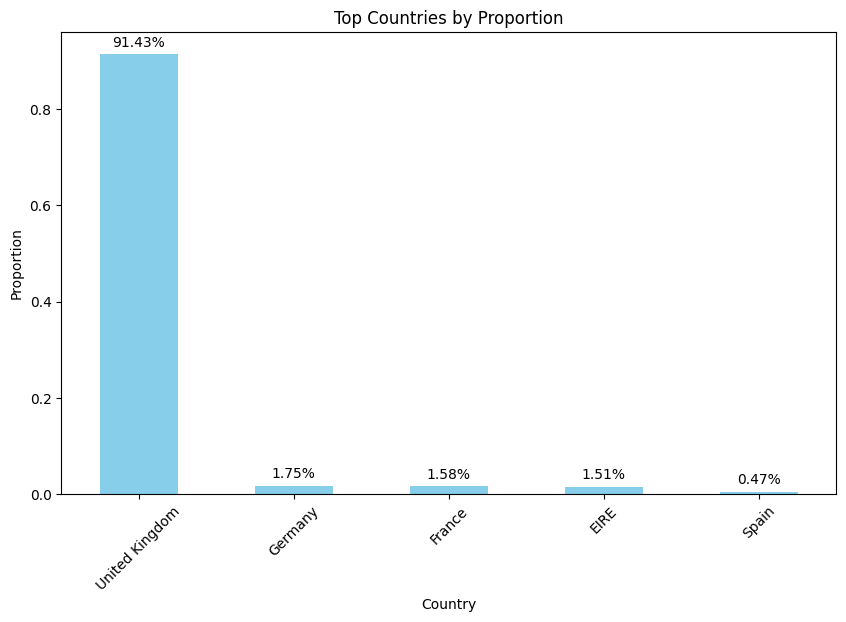

In [10]:
country_counts = df['Country'].value_counts(normalize=True).head()

plt.figure(figsize=(10, 6))
ax = country_counts.plot(kind='bar', color='skyblue')
for i, (count, value) in enumerate(zip(country_counts.index, country_counts.values)):
    ax.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

plt.title('Top Countries by Proportion')
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

In [11]:
'''Accurately representing Customer IDs is crucial for clustering customers and developing a recommendation system.
Imputing a high percentage of missing values could introduce considerable bias or noise, potentially compromising the analysis.
Given that clustering relies on understanding customer behavior and preferences, having precise data on customer identifiers is vital.
In Description, the missing values are minor compared to huge size of the data'''

'Accurately representing Customer IDs is crucial for clustering customers and developing a recommendation system.\nImputing a high percentage of missing values could introduce considerable bias or noise, potentially compromising the analysis.\nGiven that clustering relies on understanding customer behavior and preferences, having precise data on customer identifiers is vital.\nIn Description, the missing values are minor compared to huge size of the data'

In [12]:
df = df.dropna(subset=['CustomerID', 'Description'])

In [13]:
#checking if all the rows with null values are removed
df.isnull().sum().sum()

0

In [14]:
print(df.duplicated().sum())

5225


In [15]:
'''duplicates (the same thing repeated again) do not provide any new information,
hence removing them will help in achieving a cleaner dataset.'''
df.drop_duplicates(inplace=True)

In [16]:
df.shape[0] #remaining rows

401604

In [17]:
#we know that the cancelled transactions' InvoiceNo starts with "C", let's explore more
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
c_transacs = df[df['Transaction_Status'] == 'Cancelled']
c_transacs.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [18]:
#we can analyze the cancelled transactions in future so that the recommendations can be made accordingly

In [19]:
df['StockCode'].nunique() #number of unique stockcodes in the data

3684

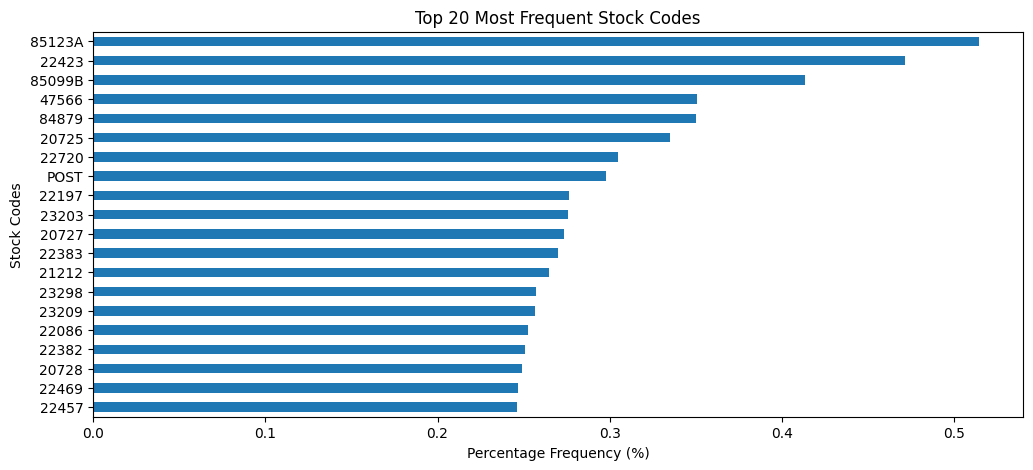

In [20]:
stockcodes_top = df['StockCode'].value_counts(normalize=True).head(20)*100

plt.figure(figsize=(12, 5))
stockcodes_top.plot(kind='barh')
plt.title('Top 20 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [21]:
#stock code anomaly "POST" observed

In [22]:
unique_stockcodes = df['StockCode'].unique()
pd.Series(unique_stockcodes).apply(lambda x: sum(c.isalnum() for c in str(x))).value_counts()

5     2798
6      877
4        3
1        2
7        1
2        1
11       1
3        1
Name: count, dtype: int64

In [23]:
pd.Series(unique_stockcodes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

5    3676
0       7
1       1
Name: count, dtype: int64

In [24]:
print([sc for sc in unique_stockcodes if sum(c.isdigit() for c in str(sc)) in (0, 1)])

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']


In [25]:
df = df[~df['StockCode'].isin(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'])]

In [26]:
df.shape[0]

399689

In [27]:
df['UnitPrice'].describe()

count    399689.000000
mean          2.907457
std           4.451881
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [28]:
print((df['UnitPrice']==0).sum())

33


In [29]:
print((df['Quantity']==0).sum())

0


In [30]:
#removing rows with unit price = 0 as they may be free or entry errors and not required
df = df[df['UnitPrice'] > 0]

In [31]:
#resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [33]:
df.shape[0]

399656

In [34]:
#Creating dataframe for comparing customers

In [35]:
#recency
#calculation for checking how recently a customer made a transaction.
#creating a new dataframe
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
most_recent_date = df['InvoiceDay'].max()
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [36]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [37]:
#frequency
#number of transactions made by each customer
total_trans = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_trans.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

#number of products purchased by each customer
total_prod = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_prod.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

#new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_trans, on='CustomerID')
customer_data = pd.merge(customer_data, total_prod, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


In [38]:
#monetary
#total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

#average transaction value for each customer
avg_trans = total_spend.merge(total_trans, on='CustomerID')
avg_trans['Average_Transaction_Value'] = avg_trans['Total_Spend'] / avg_trans['Total_Transactions']

#new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, avg_trans[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


In [39]:
#diversity of products
#number of unique products purchased by each customer
uniq_prod = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
uniq_prod.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, uniq_prod, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


In [40]:
df['Preferred_Day'] = df['InvoiceDate'].dt.dayofweek
df['Preferred_Hour'] = df['InvoiceDate'].dt.hour

days_btw = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
avg_days_btw = days_btw.groupby('CustomerID').mean().reset_index()
avg_days_btw.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)
customer_data = pd.merge(customer_data, avg_days_btw, on='CustomerID')

preferred_day = df.groupby(['CustomerID', 'Preferred_Day']).size().reset_index(name='Count')
preferred_day = preferred_day.loc[preferred_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Preferred_Day']]
preferred_hour = df.groupby(['CustomerID', 'Preferred_Hour']).size().reset_index(name='Count')
preferred_hour = preferred_hour.loc[preferred_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Preferred_Hour']]

customer_data = pd.merge(customer_data, preferred_day, on='CustomerID')
customer_data = pd.merge(customer_data, preferred_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Preferred_Day,Preferred_Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


In [41]:
#cancellation
#number of cancelled transactions for each customer
c_trans = df[df['Transaction_Status'] == 'Cancelled']
c_freq = c_trans.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
c_freq.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, c_freq, on='CustomerID', how='left')

#for customers who have not cancelled any transaction
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

#rate of cancellation
total_trans = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_trans['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Preferred_Day,Preferred_Hour,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0.0,0.0


In [42]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4285 entries, 0 to 4284
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4285 non-null   float64
 1   Days_Since_Last_Purchase        4285 non-null   int64  
 2   Total_Transactions              4285 non-null   int64  
 3   Total_Products_Purchased        4285 non-null   int64  
 4   Total_Spend                     4285 non-null   float64
 5   Average_Transaction_Value       4285 non-null   float64
 6   Unique_Products_Purchased       4285 non-null   int64  
 7   Average_Days_Between_Purchases  4285 non-null   float64
 8   Preferred_Day                   4285 non-null   int32  
 9   Preferred_Hour                  4285 non-null   int32  
 10  Cancellation_Frequency          4285 non-null   float64
 11  Cancellation_Rate               4285 non-null   float64
dtypes: float64(6), int32(2), int64(4)


In [43]:
#check for columns with same value for all the customers
same_val_cols = [col for col in df.columns if df[col].nunique() == 1]
print(len(same_val_cols))
print(same_val_cols)

0
[]


In [44]:
customer_data.nunique() #customer id is the only column with all the values unique

CustomerID                        4285
Days_Since_Last_Purchase           304
Total_Transactions                  63
Total_Products_Purchased          1755
Total_Spend                       4230
Average_Transaction_Value         4227
Unique_Products_Purchased          336
Average_Days_Between_Purchases    2594
Preferred_Day                        6
Preferred_Hour                      14
Cancellation_Frequency              23
Cancellation_Rate                  121
dtype: int64

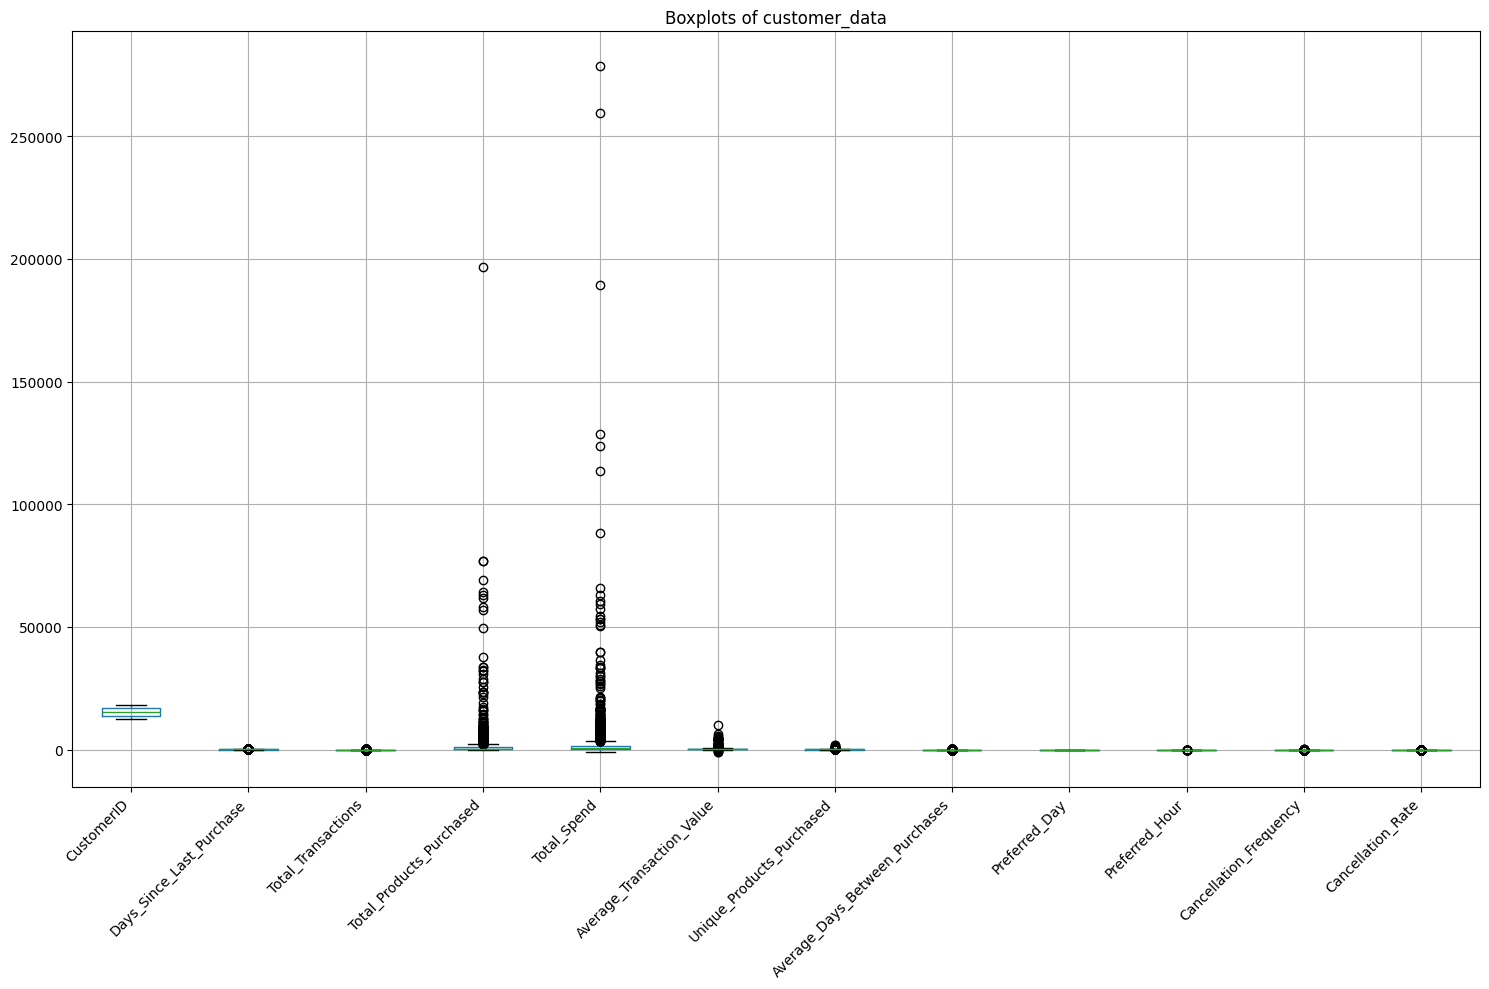

In [45]:
plt.figure(figsize=(15,10))
customer_data.boxplot()
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of customer_data')
plt.tight_layout()
plt.show()

In [46]:
customer_data.columns

Index(['CustomerID', 'Days_Since_Last_Purchase', 'Total_Transactions',
       'Total_Products_Purchased', 'Total_Spend', 'Average_Transaction_Value',
       'Unique_Products_Purchased', 'Average_Days_Between_Purchases',
       'Preferred_Day', 'Preferred_Hour', 'Cancellation_Frequency',
       'Cancellation_Rate'],
      dtype='object')

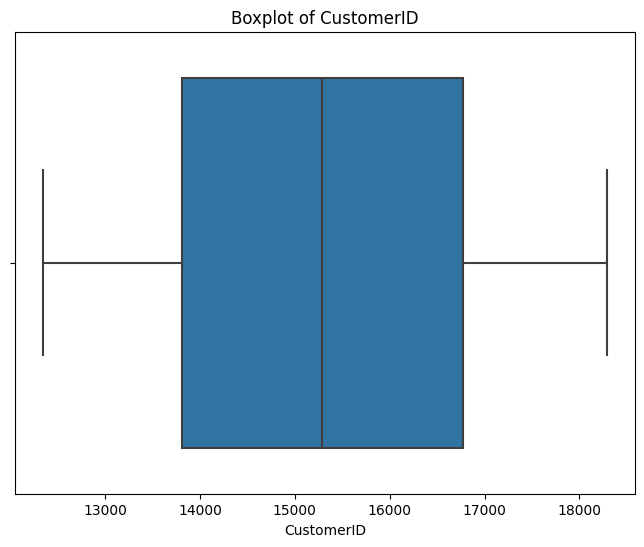

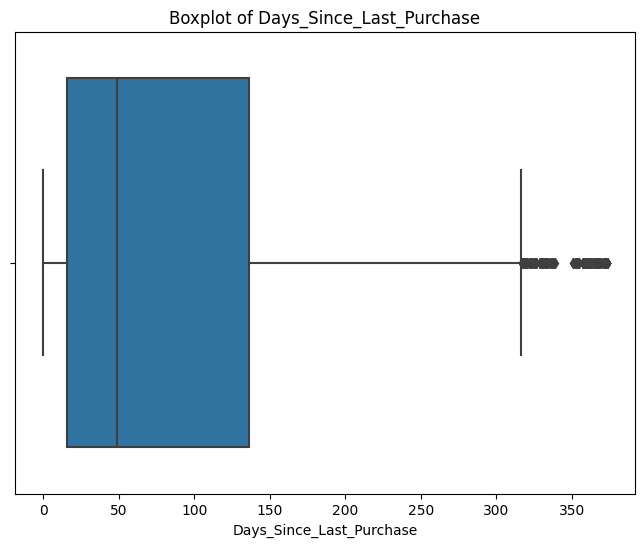

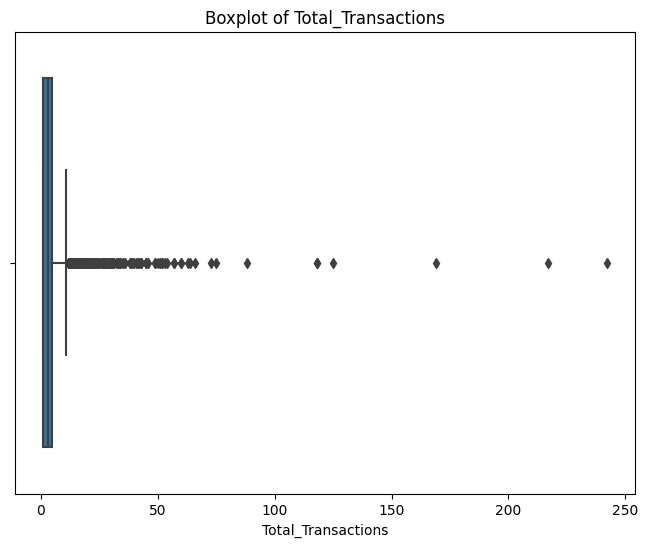

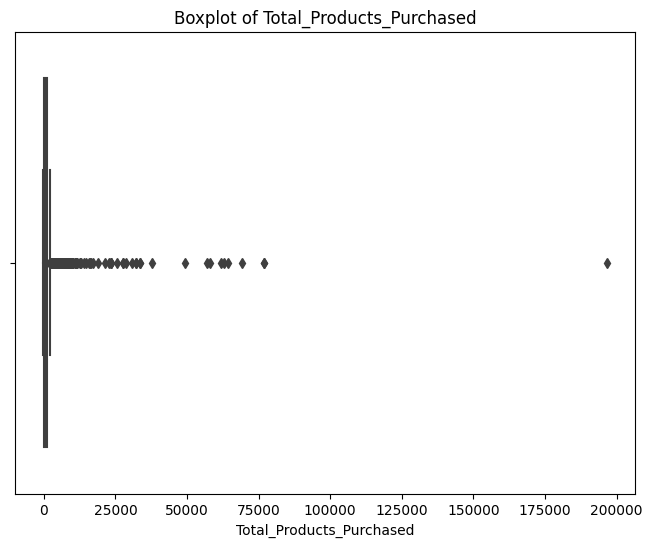

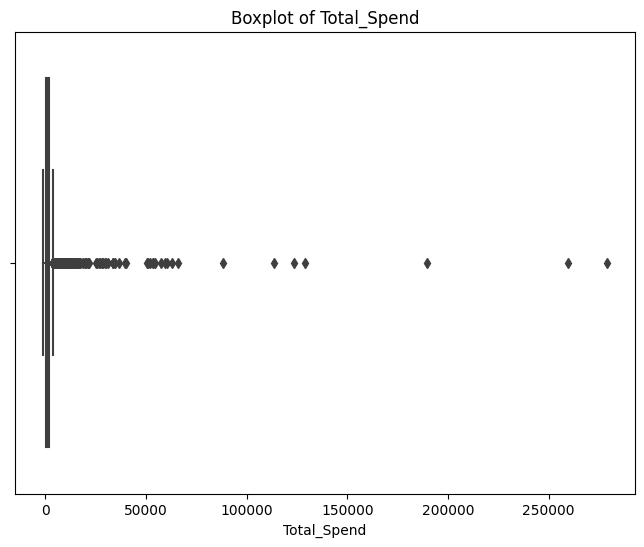

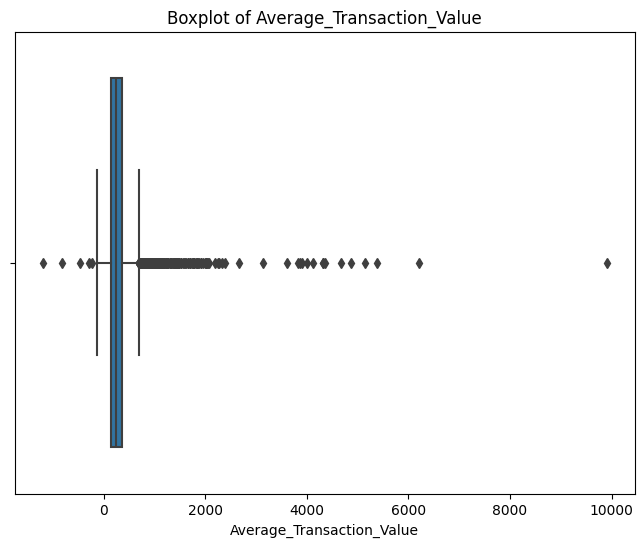

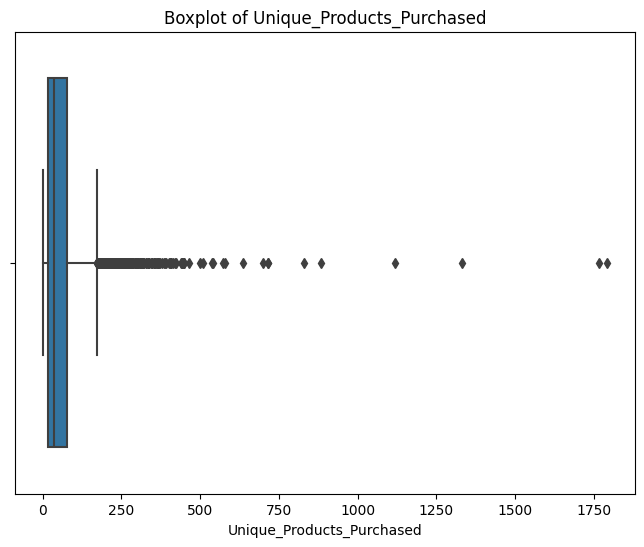

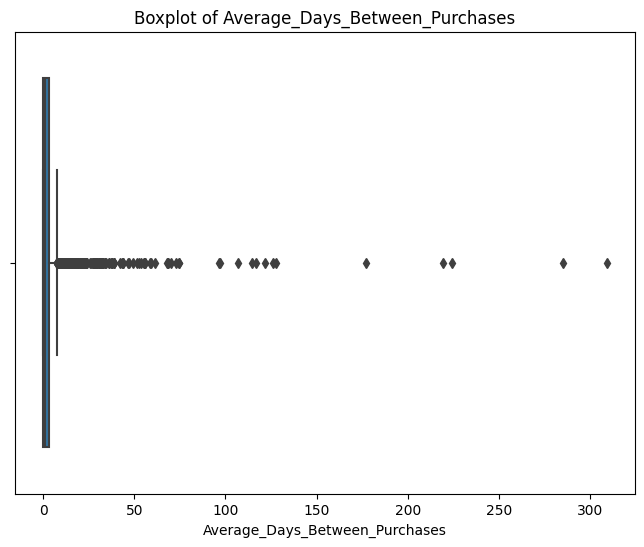

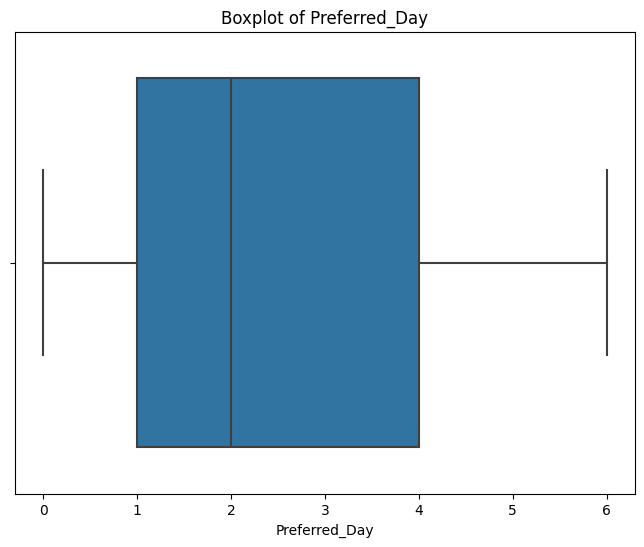

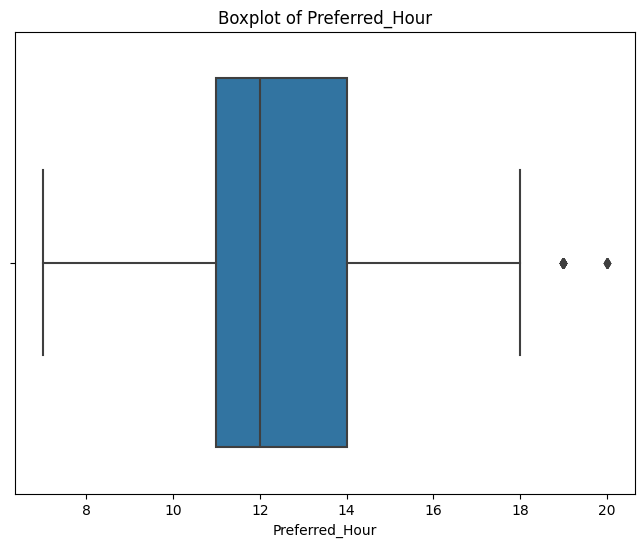

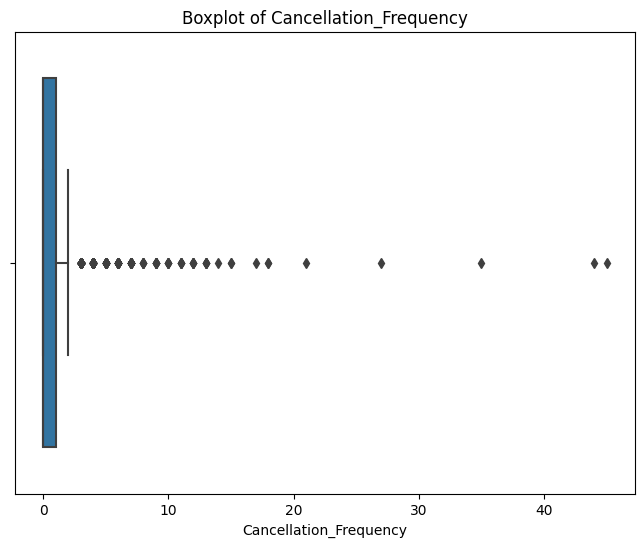

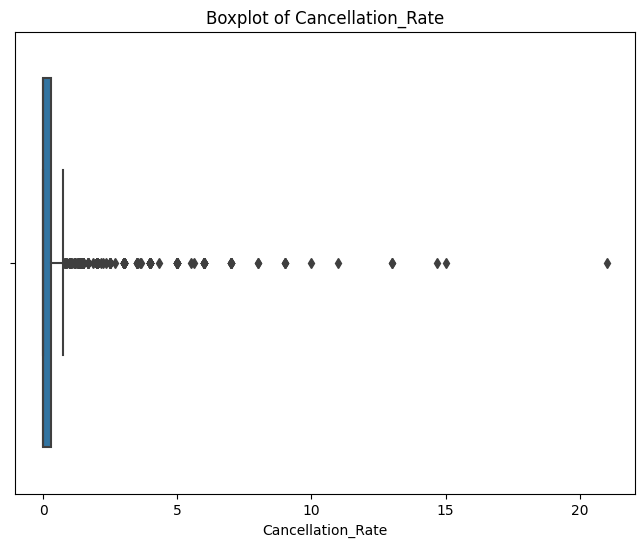

In [47]:
for col in customer_data.columns:
    if pd.api.types.is_numeric_dtype(customer_data[col]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=customer_data[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

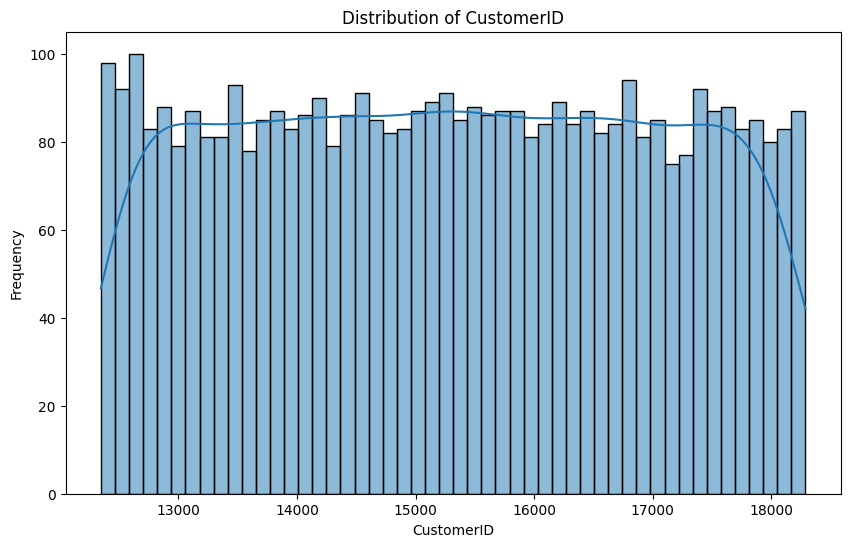

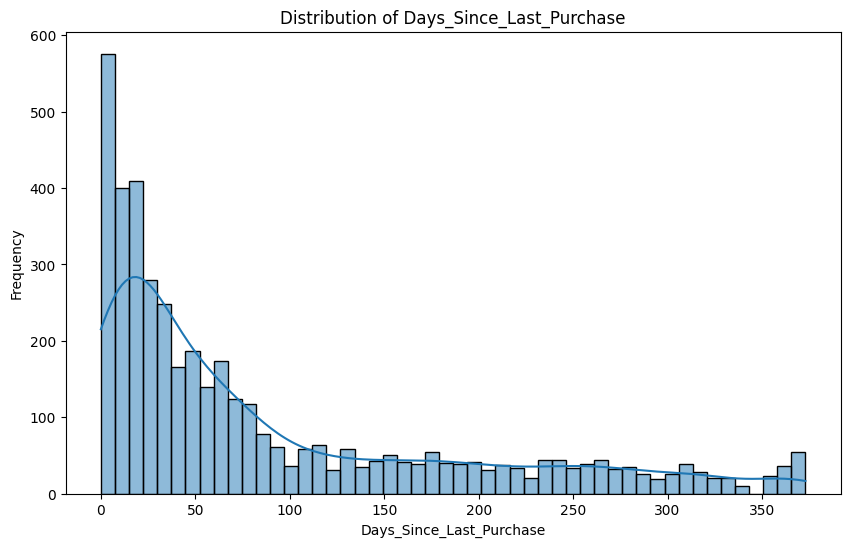

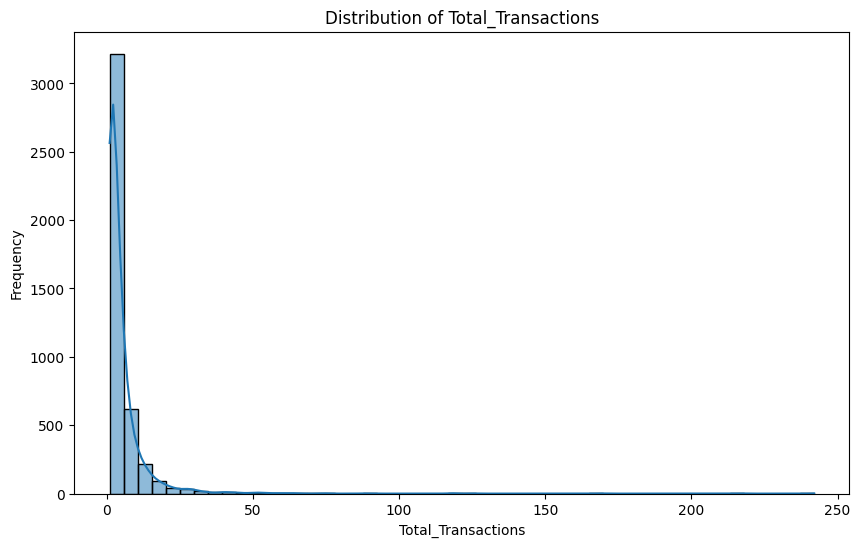

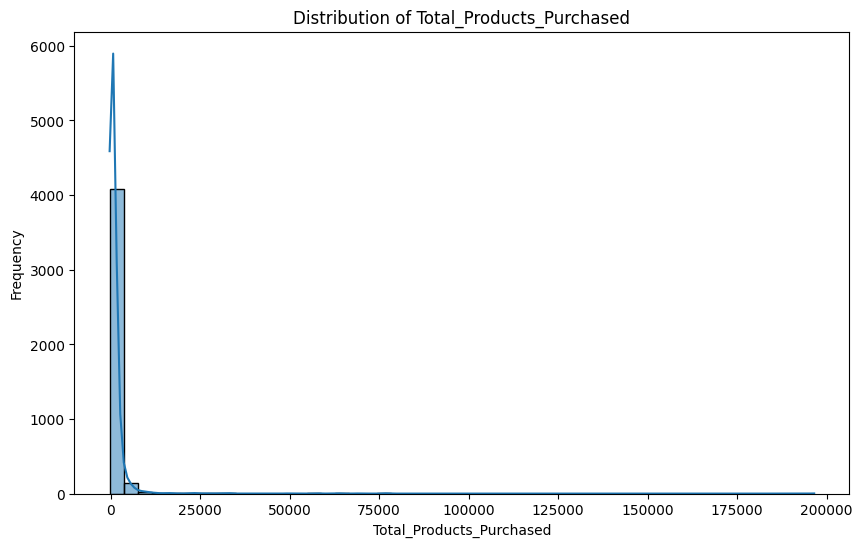

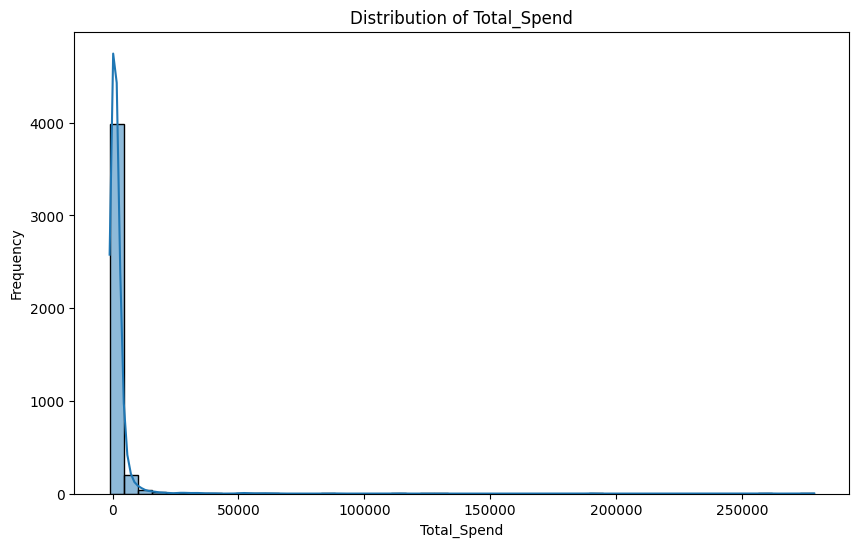

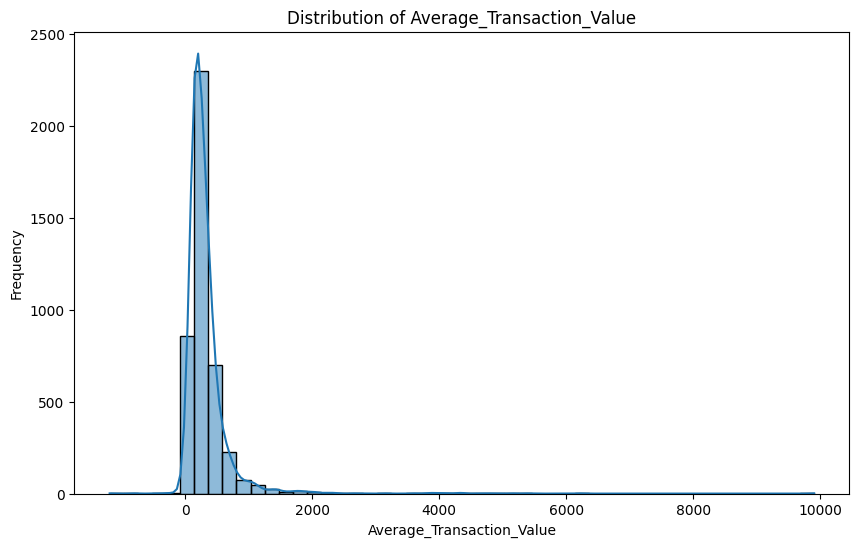

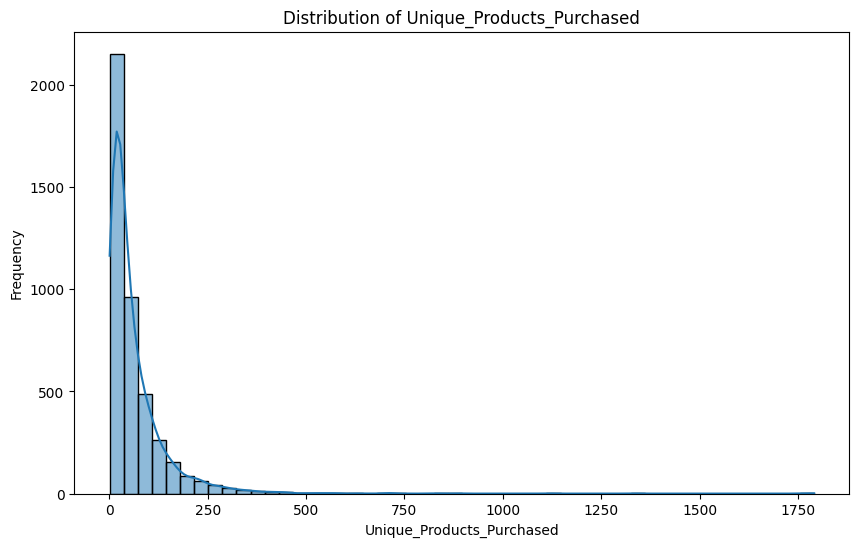

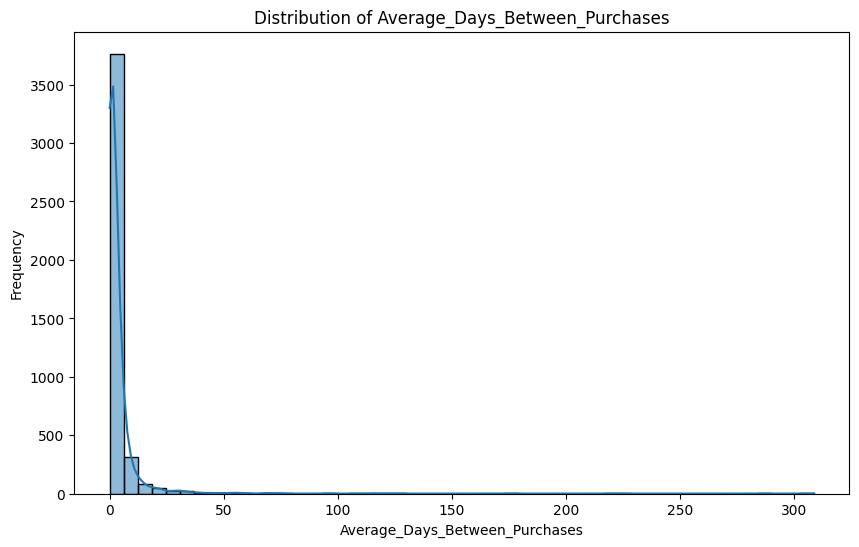

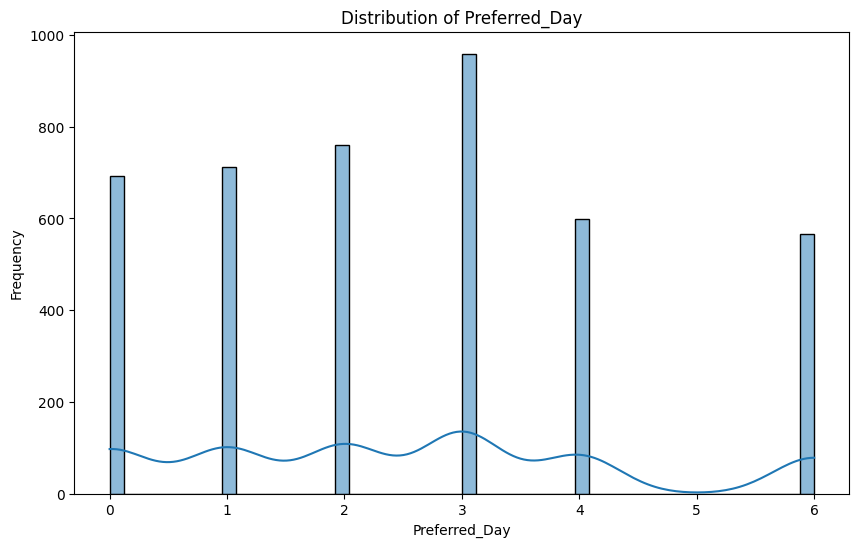

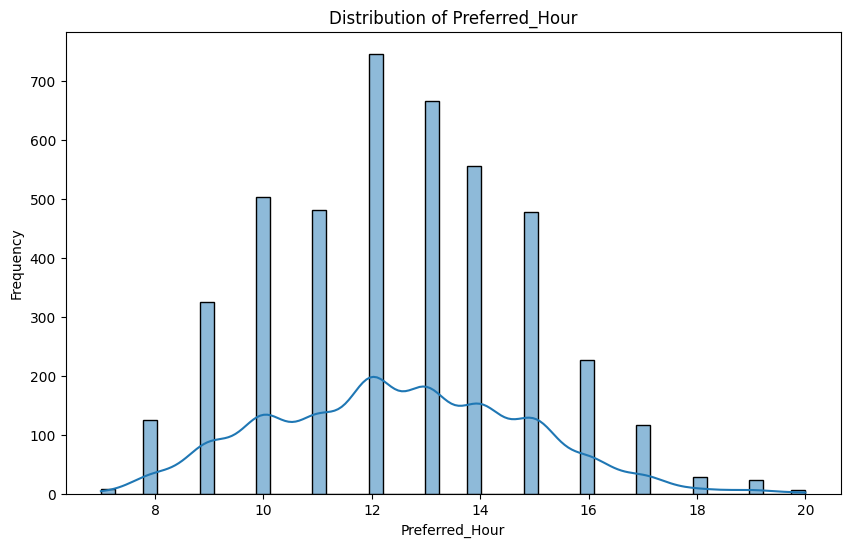

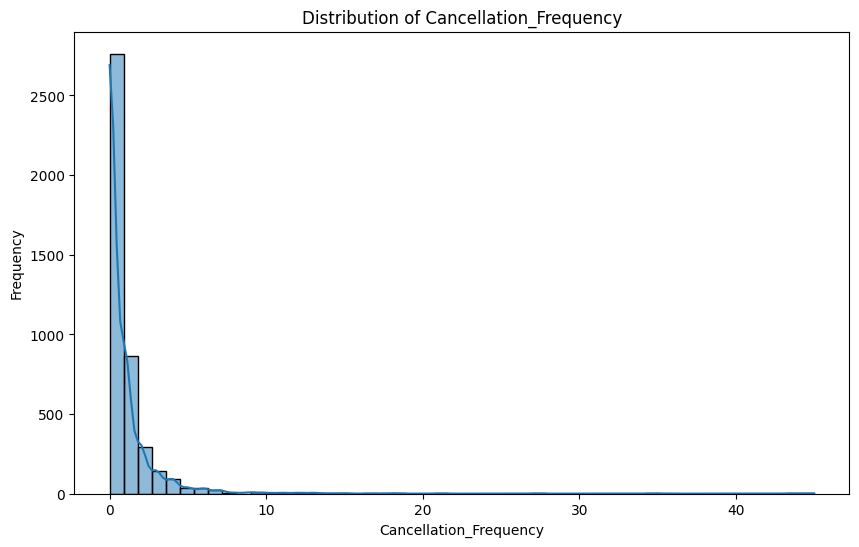

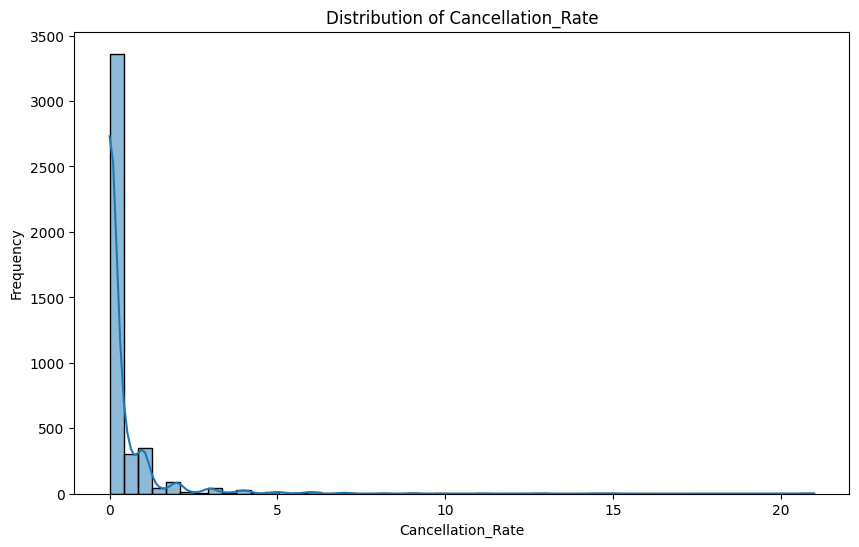

In [48]:
for column in customer_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(customer_data[column], bins=50, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

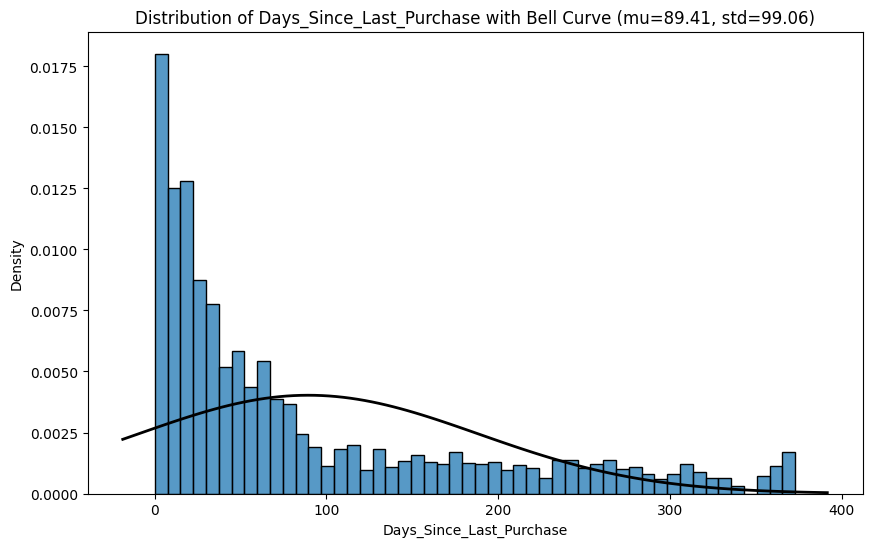

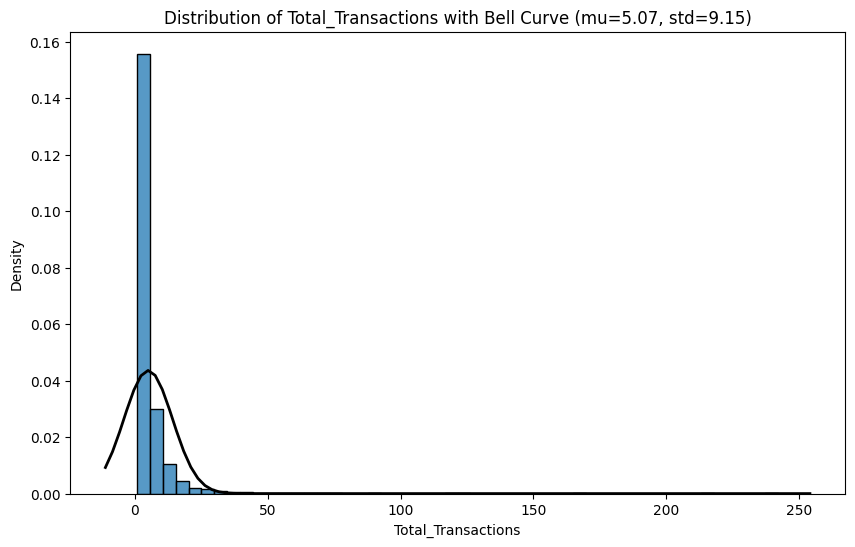

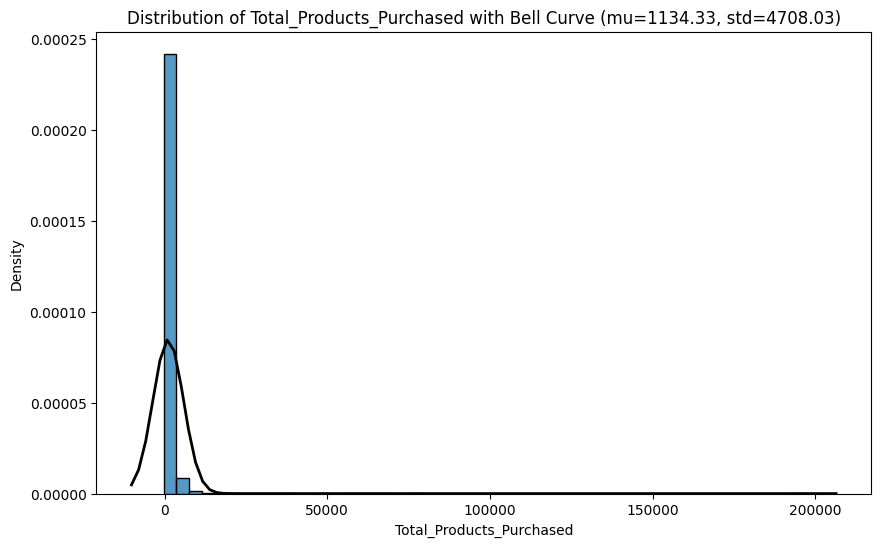

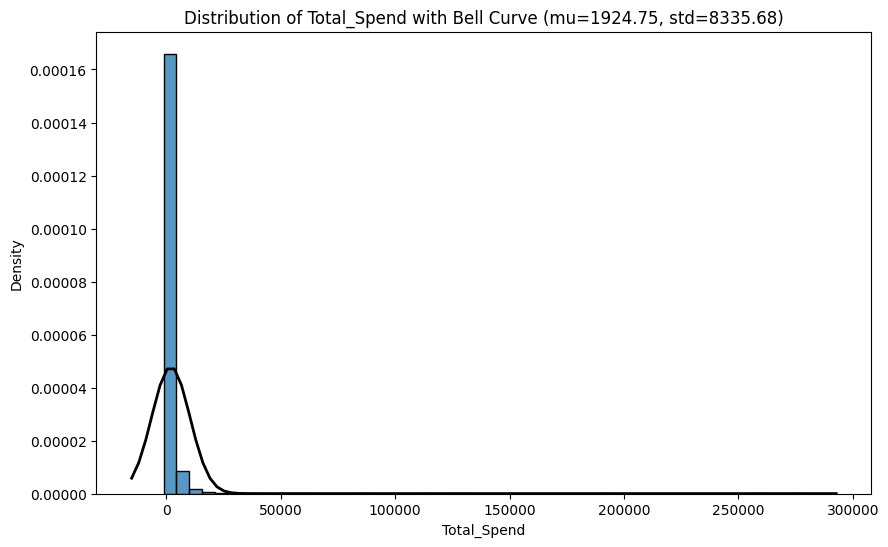

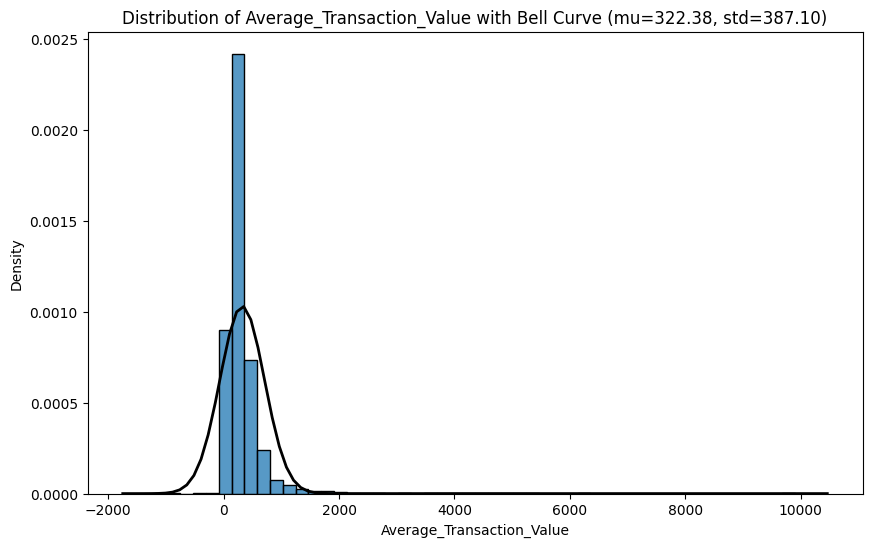

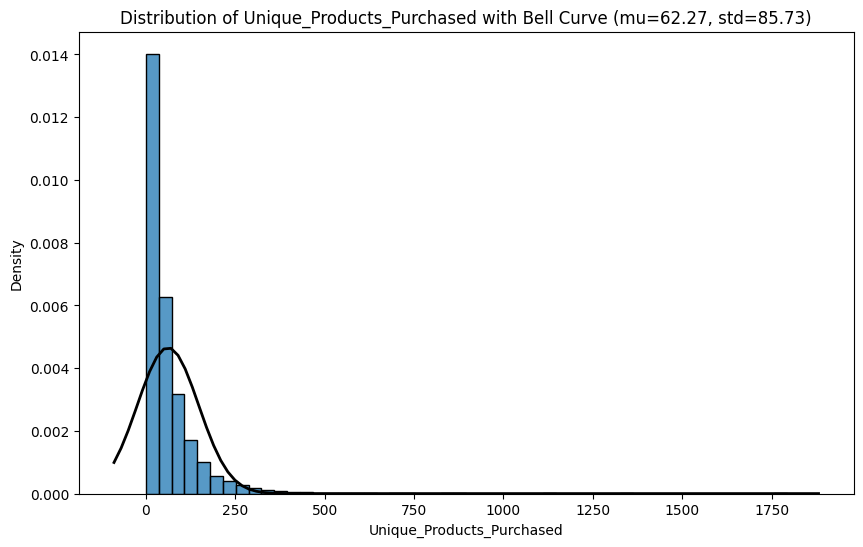

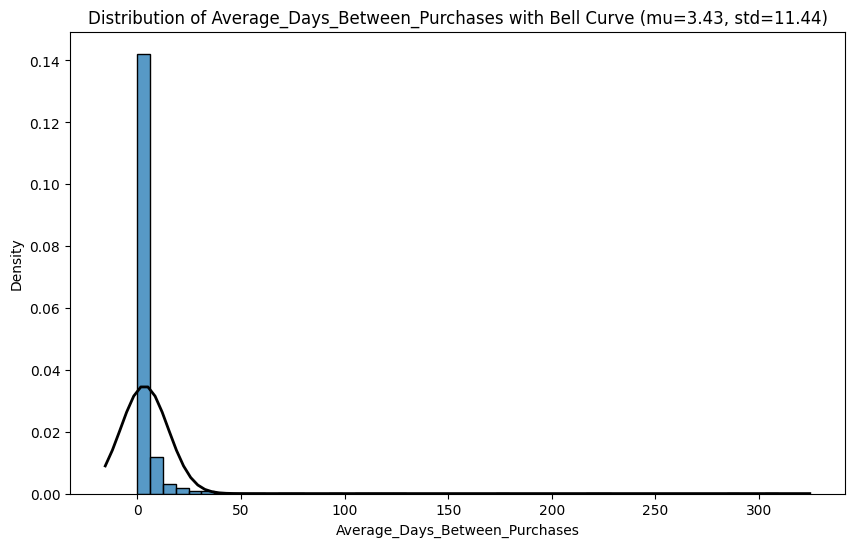

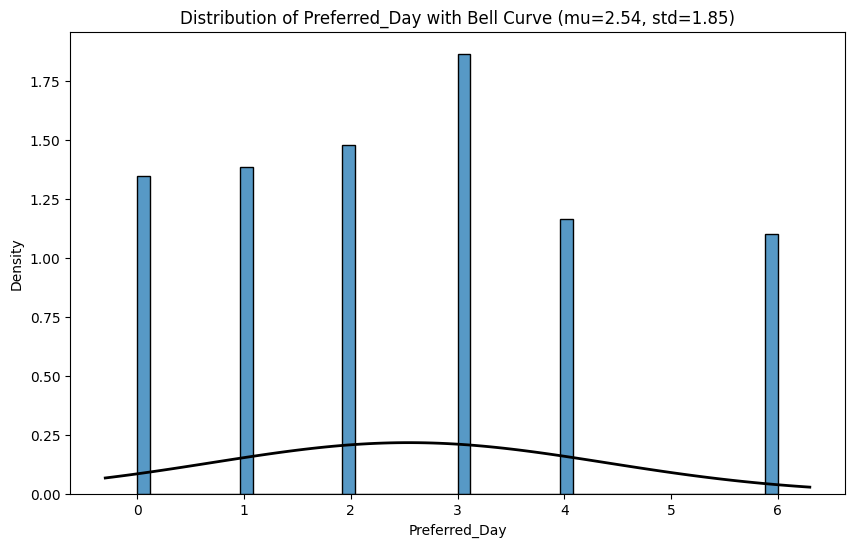

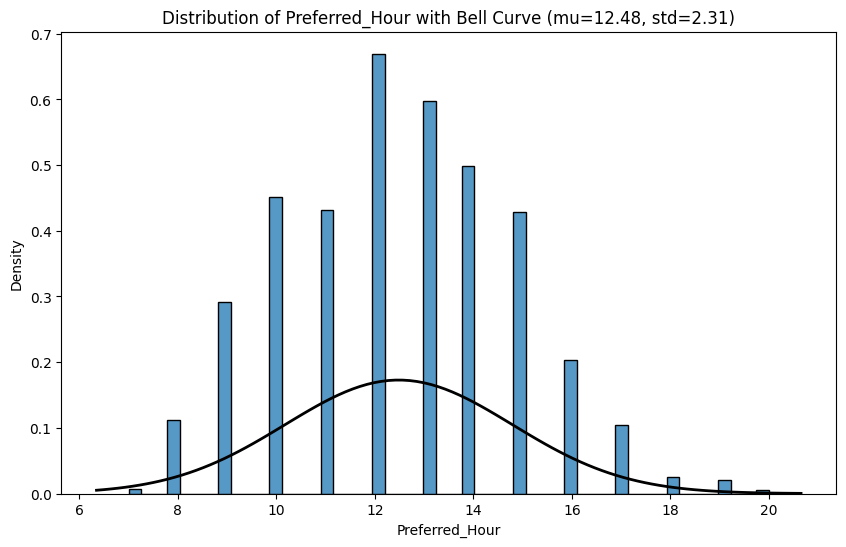

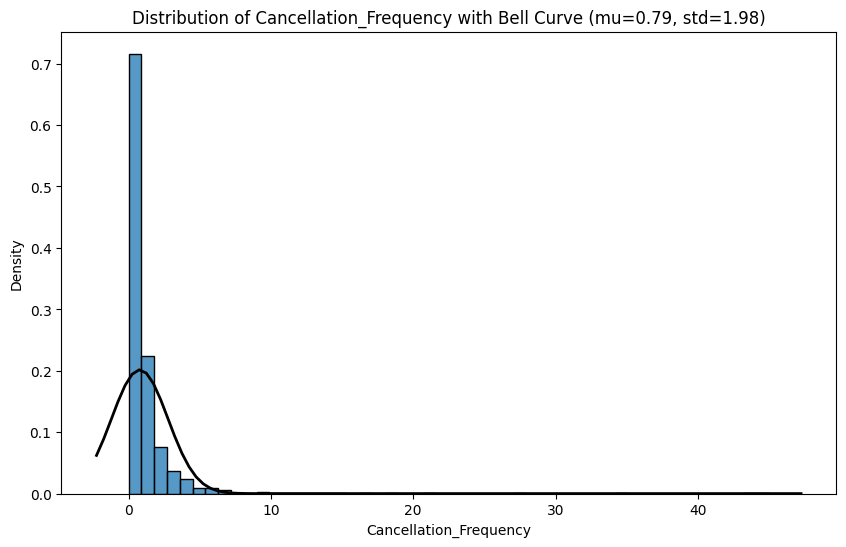

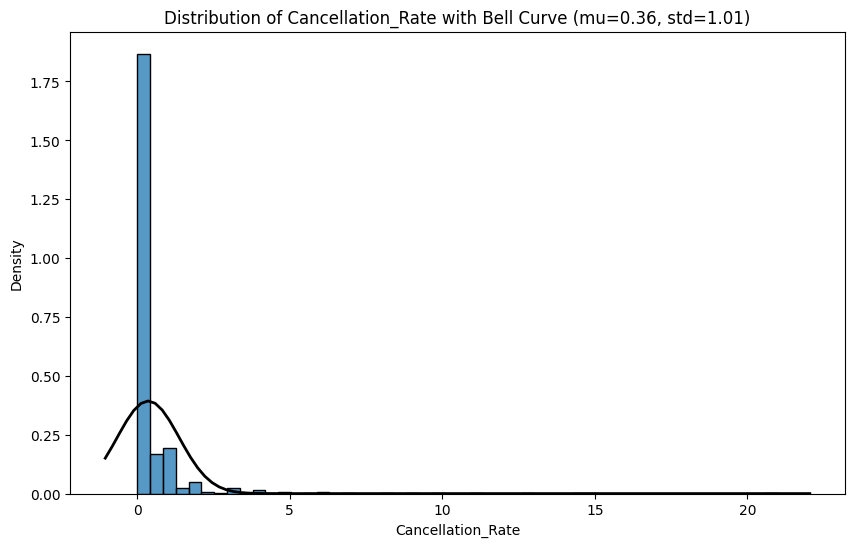

In [49]:
from scipy.stats import norm

cd = customer_data.drop(columns=['CustomerID'])
for column in cd.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(customer_data[column], bins=50, kde=False, stat='density')
    
    mu, std = norm.fit(customer_data[column])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    title = f"Distribution of {column} with Bell Curve (mu={mu:.2f}, std={std:.2f})"
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

In [50]:
#scaling the data to mean = 0, SD = 1
from sklearn.preprocessing import StandardScaler
features = ['Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Preferred_Day', 'Preferred_Hour', 'Cancellation_Frequency', 'Cancellation_Rate']
scaler = StandardScaler()
customer_data[features] = scaler.fit_transform(customer_data[features])

In [51]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

for feature in features:
    customer_data = cap_outliers(customer_data, feature)

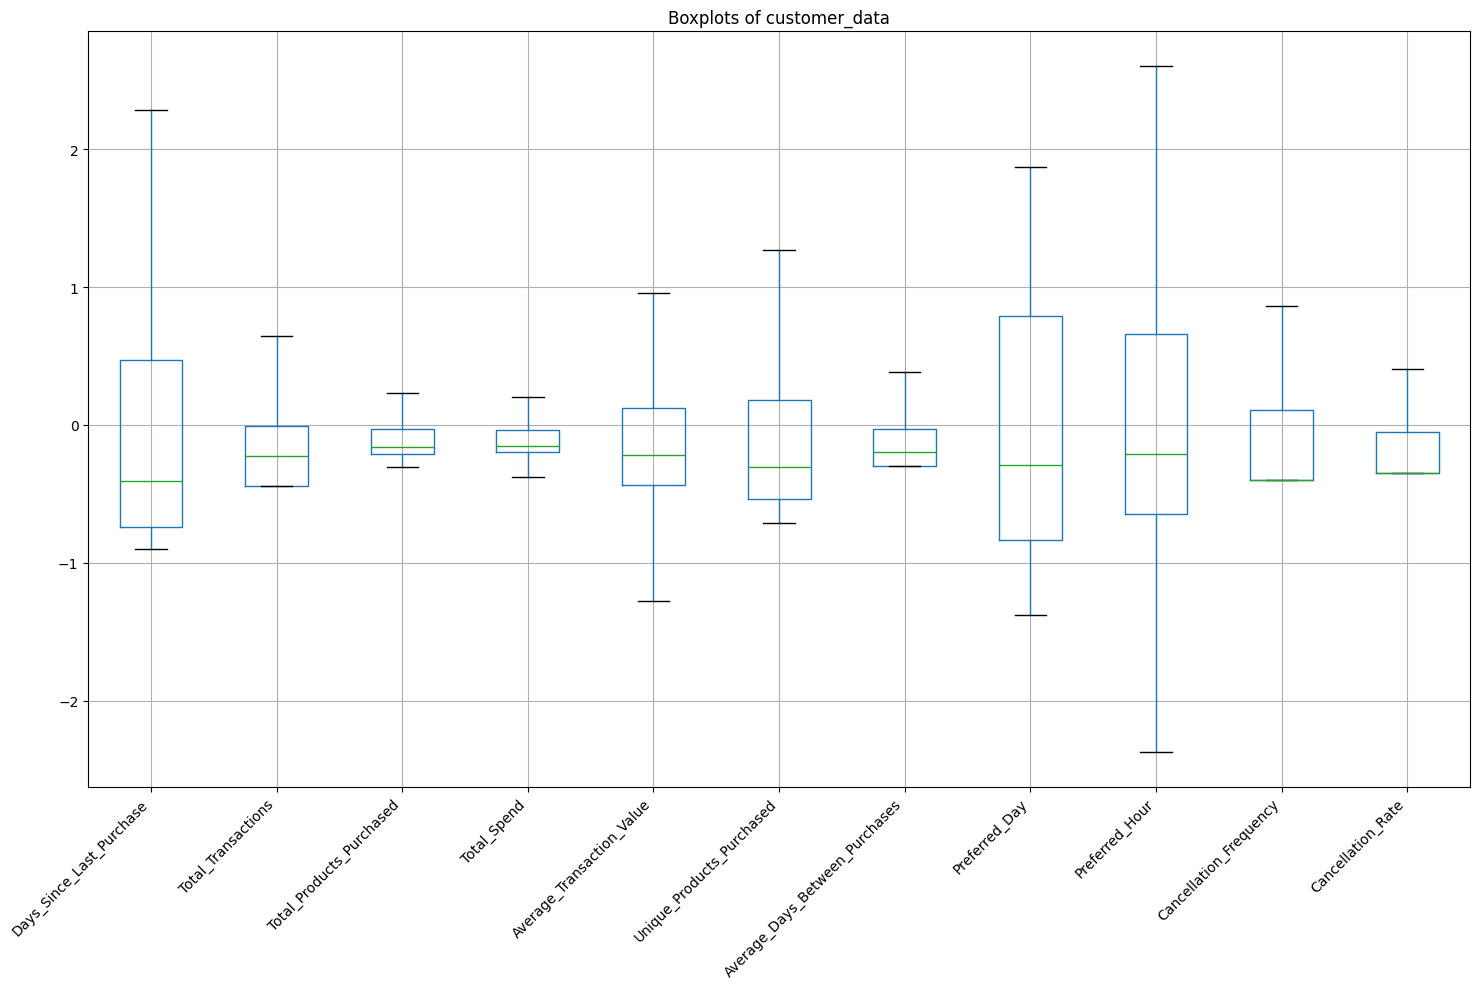

In [52]:
plt.figure(figsize=(15,10))
customer_data[features].boxplot()
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of customer_data')
plt.tight_layout()
plt.show()

In [53]:
print(customer_data.corr())

                                CustomerID  Days_Since_Last_Purchase  \
CustomerID                        1.000000                  0.005827   
Days_Since_Last_Purchase          0.005827                  1.000000   
Total_Transactions               -0.003994                 -0.446751   
Total_Products_Purchased         -0.064400                 -0.407290   
Total_Spend                      -0.070702                 -0.406191   
Average_Transaction_Value        -0.117675                 -0.108926   
Unique_Products_Purchased         0.001848                 -0.390729   
Average_Days_Between_Purchases   -0.008137                 -0.234626   
Preferred_Day                    -0.001680                 -0.001630   
Preferred_Hour                    0.077962                  0.001318   
Cancellation_Frequency           -0.043208                 -0.244803   
Cancellation_Rate                -0.020480                 -0.191375   

                                Total_Transactions  Total_Produ

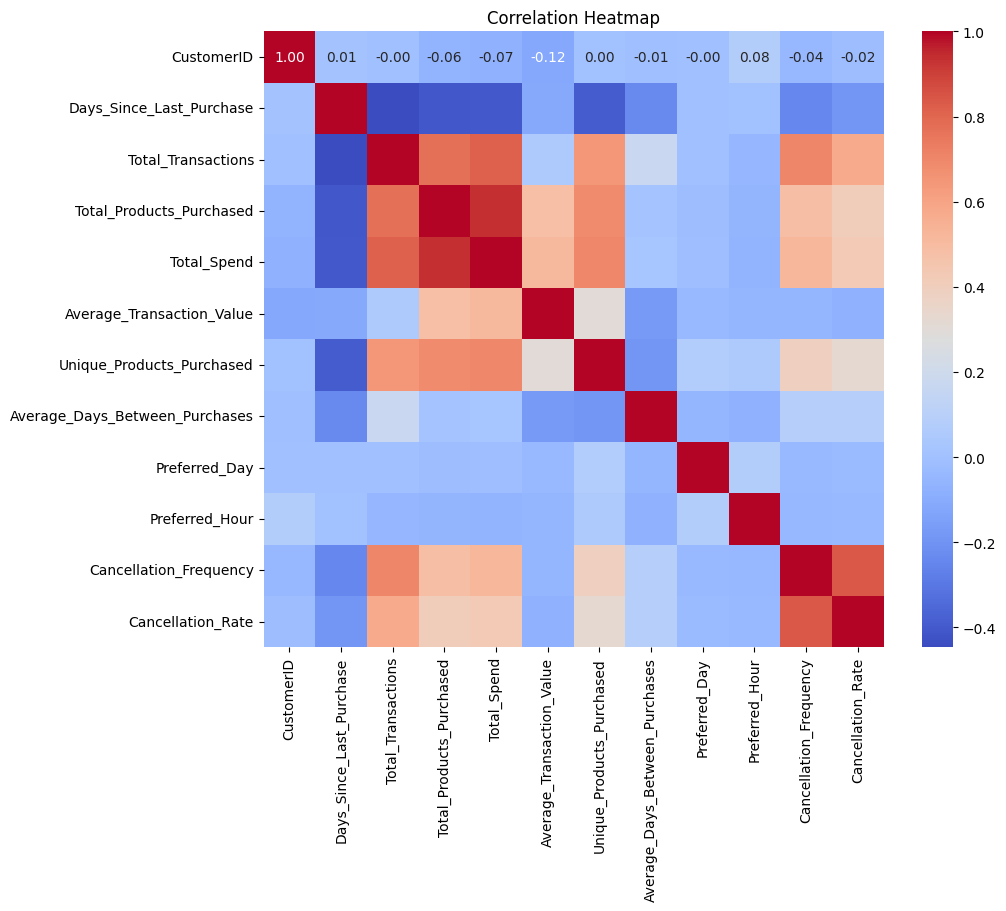

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(customer_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [55]:
'''from correlation heatmap and correlation map, we observe 'total spend' and 'total products purchased', 'cancellation rate' and 'cancellation frequency',
'total spend' and 'total transactions' have correlation >0.8, so we can remove 'total products purchased' and 'total transactions' '''
customer_data.drop(columns=['Total_Products_Purchased','Total_Transactions','Cancellation_Frequency'], inplace=True)

In [56]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4285 entries, 0 to 4284
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4285 non-null   float64
 1   Days_Since_Last_Purchase        4285 non-null   float64
 2   Total_Spend                     4285 non-null   float64
 3   Average_Transaction_Value       4285 non-null   float64
 4   Unique_Products_Purchased       4285 non-null   float64
 5   Average_Days_Between_Purchases  4285 non-null   float64
 6   Preferred_Day                   4285 non-null   float64
 7   Preferred_Hour                  4285 non-null   float64
 8   Cancellation_Rate               4285 non-null   float64
dtypes: float64(9)
memory usage: 301.4 KB


In [68]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Preferred_Day,Preferred_Hour,Cancellation_Rate
0,12346.0,2.287486,-0.230905,-0.832817,-0.714604,-0.299819,-0.834842,-1.075973,0.141005
1,12347.0,-0.882385,0.199861,0.757769,0.475123,-0.123620,-0.834842,0.656500,-0.351825
2,12348.0,-0.145441,-0.058484,0.095395,-0.481324,0.381858,0.247711,2.605533,-0.351825
3,12349.0,-0.720863,-0.056048,0.957947,0.113540,-0.299819,-1.376118,-1.509091,-0.351825
4,12350.0,2.226915,-0.195587,-0.072288,-0.539644,-0.299819,-0.293565,1.522737,-0.351825


In [70]:
customer_data.to_csv('cleaned_customer_data.csv', index=False)

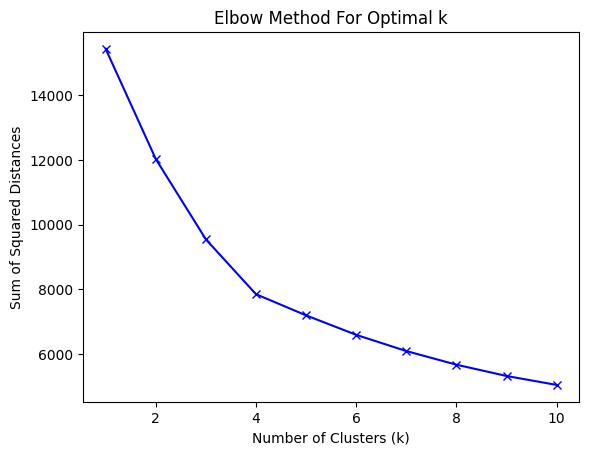

In [57]:
X = customer_data.drop('CustomerID', axis=1)
ssd = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')

plt.show()

In [58]:
#the curve starts to flatten from k = 4

In [59]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data.drop('CustomerID', axis=1))

In [60]:
customer_data['Cluster'] = customer_data['Cluster'].astype('object')
customer_data['Cluster'].describe()

count     4285
unique       4
top          0
freq      1371
Name: Cluster, dtype: int64

In [61]:
cluster_counts = customer_data['Cluster'].value_counts()
print(cluster_counts)

Cluster
0    1371
3    1240
2     842
1     832
Name: count, dtype: int64


In [62]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, customer_data['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.2361337326910901


In [63]:
from sklearn.metrics import davies_bouldin_score
features = ['Days_Since_Last_Purchase', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Preferred_Day', 'Preferred_Hour', 'Cancellation_Rate']
db_index = davies_bouldin_score(customer_data[features], customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.2924683404613273


In [64]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(customer_data[features], customer_data['Cluster'])
print(f'Calinski-Harabasz Index: {ch_index}')

Calinski-Harabasz Index: 1378.0287829904305


In [218]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Preferred_Day,Preferred_Hour,Cancellation_Rate,Cluster
0,12346.0,2.287486,-0.230905,-0.832817,-0.714604,-0.299819,-0.834842,-1.075973,0.141005,2
1,12347.0,-0.882385,0.199861,0.757769,0.475123,-0.123620,-0.834842,0.656500,-0.351825,3
2,12348.0,-0.145441,-0.058484,0.095395,-0.481324,0.381858,0.247711,2.605533,-0.351825,3
3,12349.0,-0.720863,-0.056048,0.957947,0.113540,-0.299819,-1.376118,-1.509091,-0.351825,0
4,12350.0,2.226915,-0.195587,-0.072288,-0.539644,-0.299819,-0.293565,1.522737,-0.351825,2


In [219]:
#Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df.merge(customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

#Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['Cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('Cluster').head(10)

#Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'Cluster', 'StockCode'])['Quantity'].sum().reset_index()

#Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['Cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
    customers_in_cluster = customer_data[customer_data['Cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['Cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

#Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'Cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])


In [220]:
recommendations_df.head()

,CustomerID,Cluster,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
0,12349.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES
1,12356.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22616,PACK OF 12 LONDON TISSUES
2,12358.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES
3,12359.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES,23084,RABBIT NIGHT LIGHT
4,12370.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES


In [221]:
recommendations_df.shape

(4285, 8)